# Exploration

This notebook has the objective to explore the dataset and try to figure out ways to isolate AP peaks for 1 cell and for 1 trial.

The dataset we are currently working on is ```Data_bio482.pkl```. The interesting columns of the datasets are :

- Cell_APThreshold_Slope : The slope threshold (in V/s or mV/ms) used to detect action potential onset. This value defines when dV/dt becomes large enough to mark the beginning of an AP.
- Cell_ID : unique identifiant for a cell
- Cell_Type : he genetic/physiological class of the neuron: **EXC**, **PV**, **SST**, or **VIP**. These correspond to excitatory pyramidal neurons and major GABAergic interneuron subclasses.
- Sweep_Counter : Index of the current sweep (trial) for a given cell. Each sweep is a separate recording segment within the same cell.
- Sweep_Type : The type of activity we are recording. Sweep_type can be **free whisking**, **active touch** and **passive contact**.
- Sweep_MembranePotential : The raw membrane potential trace (Vm) for that sweep, stored as an array of voltage values sampled over time.
- Sweep_MembranePotential_SamplingRate : The sampling rate (in Hz) used to record the membrane potential trace. Indicates how many Vm samples per second are collected during this sweep (e.g., 20 kHz, 30 kHz).

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.helpers import *
from scripts.utils import remove_top_right_frame, jitter_scatterplot

In [2]:
data_df = pd.read_pickle('Data/Data_bio482.pkl')

In [18]:
data_df.columns

Index(['Cell_APThreshold_Slope', 'Cell_Anatomy', 'Cell_Counter', 'Cell_Depth',
       'Cell_ID', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type',
       'Cell_tdTomatoExpressing', 'Mouse_DateOfBirth', 'Mouse_Genotype',
       'Mouse_Name', 'Mouse_Sex', 'Sweep_ActiveContactTimes', 'Sweep_Counter',
       'Sweep_MembranePotential', 'Sweep_MembranePotential_SamplingRate',
       'Sweep_PassiveContactTimes', 'Sweep_QuietTimes', 'Sweep_StartTime',
       'Sweep_Type', 'Sweep_WhiskerAngle', 'Sweep_WhiskerAngle_SamplingRate',
       'Sweep_WhiskingTimes'],
      dtype='object')

In [42]:
data_df.shape

(831, 24)

In [38]:
# PARAMETERS
sweep_type = 'free whisking' # we will work only with free whisking
cell_type = "EXC"  # change to EXC, SST, VIP to re-run
window_duration = 0.01  # 10 ms. We can change that later or do many graphs to see difference

# we therefore filter the dataset to only have data related to free whisking condition
data_df_subset = data_df[
    (data_df["Cell_Type"] == cell_type) &
    (data_df["Sweep_Type"] == sweep_type)
].reset_index(drop=True)

cell_ids = data_df_subset['Cell_ID'].unique().tolist()

# Get data subset for that cell
cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

# Get sweeps/trials recorded for that cell, that we are going to iterate over
trial_list = cell_df.Sweep_Counter.values
trial=trial_list[1]

# Get current trial data
cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

In [41]:
cell_trial_df

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
123,10.0,L2/3;C3,1.0,320.0,SC923_1,L2/3,C2,EXC,False,NaN,...,9.0,"[-0.052834375, -0.05286250000000001, -0.052865...",20000.0,nan,"[[0.002, 0.016], [1.948, 2.498], [4.488, 5.084...",2007.0,free whisking,"[1.1517276000976588, 4.938667907714843, 4.5802...",100.0,"[[1.116, 1.818], [2.592, 2.988], [3.542, 3.97]..."


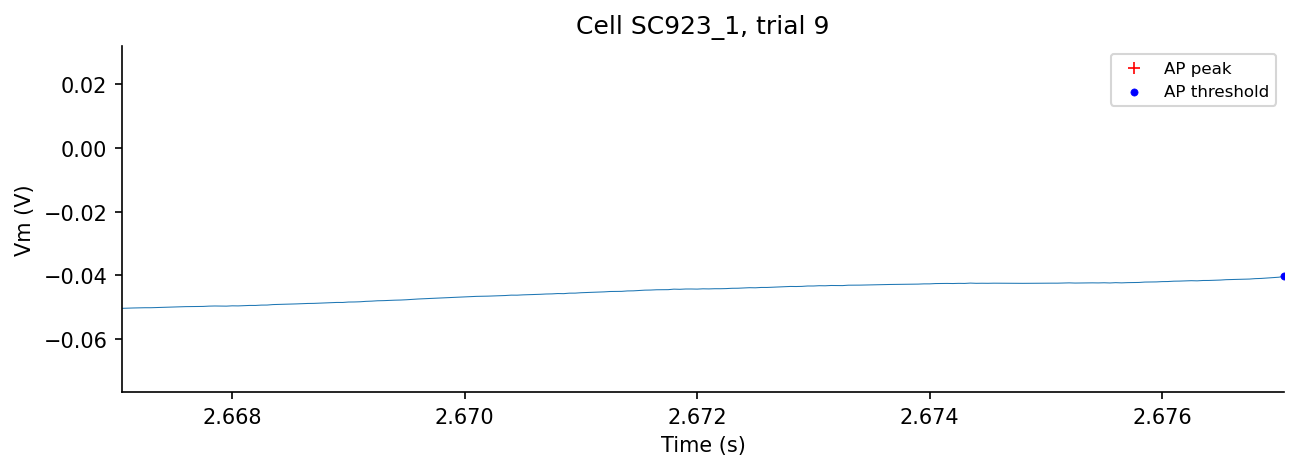

In [46]:
def plot_cell_dynamics(cell_id, cell_trial):

    sr_vm = float(cell_trial_df["Sweep_MembranePotential_SamplingRate"].iloc[0])     # e.g. 20000 Hz
    membrane_potential = np.asarray(cell_trial_df["Sweep_MembranePotential"].iloc[0])  # 1D array
    ap_vm_deriv_thresh = float(cell_trial_df["Cell_APThreshold_Slope"].iloc[0])     # slope threshold for AP detection

    # 20 seconds for each cell since sr_vm = 20 000 and Sweep_MembranePotential.shape = 400 000 points recorded
    trial_rec_duration = len(membrane_potential) / sr_vm   
    
    # use the Function_Detect_APs to calculate thresh time, thresh point...
    ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
    
    # Defaults if no spikes
    ap_thresh_times = np.array([])
    ap_thresh_vm    = np.array([])
    ap_peak_times   = np.array([])
    ap_peak_vm      = np.array([])
    ap_duration     = np.array([])
    
    if ap_params is not None and np.size(ap_params) > 0 and np.any(ap_params):
        # Ensure 2D shape even if only one AP is returned
        ap_params = np.atleast_2d(ap_params)
    
        ap_thresh_times = np.asarray(ap_params[:, 0], dtype=float)  # seconds
        ap_thresh_vm    = np.asarray(ap_params[:, 1], dtype=float)  # volts
        ap_peak_times   = np.asarray(ap_params[:, 2], dtype=float)  # seconds
        ap_peak_vm      = np.asarray(ap_params[:, 3], dtype=float)  # volts
        ap_duration     = np.asarray(ap_params[:, 5], dtype=float)
    

        vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
    else:
        vm_sub = membrane_potential.copy()
    
    time = np.arange(len(membrane_potential)) / sr_vm
    
    ap_peak_index   = np.round(ap_peak_times * sr_vm).astype(int)
    ap_thresh_index = np.round(ap_thresh_times * sr_vm).astype(int)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=150)
    remove_top_right_frame(ax)
    
    ax.set_title(f"Cell {cell_id}, trial {int(cell_trial)}")
    
    ax.plot(time, membrane_potential, lw=0.5, zorder=0)
    
    # Plot markers only if there are spikes
    if ap_peak_times.size > 0:
        ax.scatter(ap_peak_times, ap_peak_vm, marker="+", color="r", s=30, lw=0.8, label="AP peak")
    if ap_thresh_times.size > 0:
        ax.scatter(ap_thresh_times, ap_thresh_vm, marker="o", color="b", s=12, lw=0.3, label="AP threshold")
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Vm (V)")
    
    # Zoom controls
    window_sec = 0.01  # 10 ms
    
    # Example: zoom on first spike pre-threshold window
    if ap_thresh_times.size > 0:
        ax.set_xlim(ap_thresh_times[0] - window_sec, ap_thresh_times[0])
    
    #ax.set_xlim(0, trial_rec_duration)  # full sweep (e.g., 0–20 s)
    ax.legend(loc="upper right", fontsize=8)
    plt.show()

## Insights about the graph

In this trial (Cell SC923_1, trial 5), we detected **125 action potentials** (APs) over a **20-second** recording window.  
You can zoom into specific events by adjusting the axis limits with:

```python
plt.xlim(start, end)
```

The plot above shows an example: the 10 ms window just before the AP threshold of the very **first** spike.

### Understanding the output of ```Function_Detect_APs```

The function ```Function_Detect_APs``` returns a matrix ap_params where each row corresponds to one detected AP.
From this matrix, we extract:
    
```python
if (ap_params.any()):
    ap_thresh_times = ap_params[:,0] 
    ap_thresh_vm = ap_params[:,1]
    ap_peak_times = ap_params[:,2]
    ap_peak_vm = ap_params[:,3]
    ap_duration = ap_params[:,5]
```

**What each variable represents :** 
- ```ap_thresh_times``` : An array of 125 elements, each giving the time (in seconds) when the membrane potential first crosses the upstroke threshold of an AP.
- ```ap_thresh_vm``` : An array of 125 elements, containing the membrane potential (in volts) at the exact threshold crossing for each spike.
- ```ap_peak_times``` : An array of 125 elements, giving the precise time (in seconds) when each AP reaches its peak.
- ```ap_peak_vm``` : An array of 125 elements, giving the membrane potential (in volts) at the peak of each spike.
- ```ap_duration``` : An array of 125 elements, storing the duration of each AP (e.g., peak-to-half-peak width).

For subthreshold analysis, we are most interested in the AP threshold time (```ap_thresh_times```) and AP threshold voltage (```ap_thresh_vm```), because they define precisely when and from what state the neuron initiates a spike.
By converting each threshold time into an index and taking a 10 ms window immediately before threshold, we can extract: 

- the mean $V_m$ in that window,
- the slope (dV/dt),
- as well as any other features relevant to spike initiation.

In [59]:
def extract_pre_spike_windows(dataframe, membrane_potential, thresh_indices, sr_vm, window_ms=10):
    """ For each spike threshold index, extract Vm in the window (window_ms) preceding the threshold. Returns a list of arrays. """ 
    
    for _, row in dataframe.iterrows(): 
        window_samples = int((window_ms/1000) * sr_vm) 
        pre_spike_segments = [] 
        for idx in thresh_indices: 
            start = idx - window_samples 
            end = idx # boundary to make sure we are not out of range 
            
            if start < 0: 
                continue 
            if end > len(membrane_potential): 
                continue 
                
            segment = membrane_potential[start:end] 
            
            pre_spike_segments.append(segment) 
            
            return pre_spike_segments # = L

def extract_pre_spike_windows(dataframe, window_ms=10):

    all_segments = []
    
    for _, row in dataframe.iterrows():

        cell_id = row['Cell_ID']
        cell_trial = row['Sweep_Counter']
        
        membrane_potential = np.asarray(row["Sweep_MembranePotential"])
        sr_vm = float(row["Sweep_MembranePotential_SamplingRate"])
        ap_vm_deriv_thresh = float(row["Cell_APThreshold_Slope"])

        # Detect APs for this sweep
        ap_params = Function_Detect_APs(
            membrane_potential,
            sr_vm,
            ap_vm_deriv_thresh
        )

        if ap_params is None or np.size(ap_params) == 0 or not np.any(ap_params):
            continue

        ap_params = np.atleast_2d(ap_params)
        ap_thresh_times = ap_params[:, 0]
        ap_thresh_index = np.round(ap_thresh_times * sr_vm).astype(int)

        # --- extract windows for this sweep ---
        pre_spike_segments = extract_pre_spike_windows_single_sweep(
            membrane_potential,
            ap_thresh_index,
            sr_vm,
            window_ms
        )

        all_segments.append(pre_spike_segments)

        return all_segments
            

In [64]:
all_segments = extract_pre_spike_windows(subset)
for seg in all_segments:
    print(type(seg))
    print(len(seg))
#print(f"The number of pre-spike segments is {len(segments_all)}")

<class 'list'>
65


In [119]:
from scipy.stats import linregress

def compute_pre_spike_features(segment, sr):
    """
    Input: 1D Vm window (numpy array)
    Returns: the feature we want to compute for each spike. 
    - mean Vm
    - linear regression slope dV/dt
    - ...
    """
    N = len(segment)
    t = np.linspace(-N/sr, 0, N)  # time ending at threshold (0)
    
    # Linear regression Vm = a*t + b
    slope, intercept, r, p, se = linregress(t, segment)

    Vm_mean = np.mean(segment)

    return Vm_mean, slope

In [145]:
# our time frame in ms. We don't declare the value as constant (WINDOW_MS) yet since we might change it
window_sec = 0.010   # 10 ms

# will store the per-spike dataframes for final concatenation
stores_df = []

for seg, t_idx in zip(pre_spike_segments_10ms, ap_thresh_index):

    # compute features for this spike
    Vm_mean, slope = compute_pre_spike_features(seg, sr_vm)

    # build one-row dictionary
    per_spike_feature = {
        "cell_ID": cell_trial_df["Cell_ID"].iloc[0], # we store also the cell ID for later if we merge other dataframes
        # from other cells with this one
        "threshold_index": t_idx,
        "time_window_start [sec]": (t_idx / sr_vm) - window_sec, 
        "time_window_end = threshold_time [sec]": t_idx / sr_vm,
        "Vm_thresh [mV]": membrane_potential[t_idx] * 1000, # convert volts in millivolts
        "Vm_mean_10ms [mV]": round(Vm_mean * 1000, 2), # convert volts in millivolts. 
        "slope_10ms": round(slope, 2)
    }

    # convert to a 1-row DataFrame (IMPORTANT: wrap dict in a list)
    single_spike_df = pd.DataFrame([per_spike_feature])

    # store for concatenation later
    stores_df.append(single_spike_df)

# concatenate all spikes from this cell
single_cell_all_spikes_df = pd.concat(stores_df, ignore_index=True)

In [151]:
single_cell_all_spikes_df

,cell_ID,threshold_index,time_window_start [sec],time_window_end = threshold_time [sec],Vm_thresh [mV],Vm_mean_10ms [mV],slope_10ms
0,SC923_1,18102,0.89510,0.90510,-42.790625,-48.73,0.98
1,SC923_1,19653,0.97265,0.98265,-41.315625,-45.27,0.79
2,SC923_1,20829,1.03145,1.04145,-41.828125,-48.13,0.86
3,SC923_1,25906,1.28530,1.29530,-42.834375,-48.28,0.51
4,SC923_1,29372,1.45860,1.46860,-42.993750,-49.07,0.88
...,...,...,...,...,...,...,...
120,SC923_1,387290,19.35450,19.36450,-42.871875,-50.39,0.91
121,SC923_1,391629,19.57145,19.58145,-41.400000,-47.30,0.80
122,SC923_1,397574,19.86870,19.87870,-42.553125,-46.58,0.43
123,SC923_1,397722,19.87610,19.88610,-38.159375,-35.60,-0.60


In [169]:
single_cell_all_spikes_df.describe()

,threshold_index,time_window_start [sec],time_window_end = threshold_time [sec],Vm_thresh [mV],Vm_mean_10ms [mV],slope_10ms
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,205131.800000,10.246590,10.256590,-38.928200,-43.186000,0.331200
std,92748.847384,4.637442,4.637442,2.609549,4.416242,0.747916
min,18102.000000,0.895100,0.905100,-44.209375,-53.850000,-4.680000
25%,142021.000000,7.091050,7.101050,-40.815625,-46.150000,0.220000
50%,191182.000000,9.549100,9.559100,-39.115625,-43.350000,0.450000
75%,275606.000000,13.770300,13.780300,-37.400000,-41.390000,0.700000
max,399260.000000,19.953000,19.963000,-30.750000,-22.350000,1.420000


## What can we do next ?

We can :

1. Cap the floating points to 2 so we can see if we have exact **Vm_mean_10ms** or **slope_10ms** between two or many AP. 
2. Check if a 10 [ms] time window before an AP contains one or more APs. 

In [161]:
# 2. Check if a 10 [ms] time window before an AP contains one or more APs

# Window size in seconds
window_sec = 0.010   # 10 ms

# we store True/False for each spike
window_contains_AP = []

for i, t_i in enumerate(ap_thresh_times):

    # Start and end of the pre-spike window
    t_start = t_i - window_sec
    t_end   = t_i

    # Check if any OTHER spike time falls inside this window
    # Exclude the spike itself using index check
    exists_other_spike = np.any([
        (j != i) and (t_start <= t_j < t_end)
        for j, t_j in enumerate(ap_thresh_times)
    ])

    window_contains_AP.append(exists_other_spike)

window_contains_AP = np.array(window_contains_AP)

In [165]:
# we can check which peaks contains other peaks in their time frame

# we store the peak index.
check_peak_list = []
for i, boo in enumerate(window_contains_AP):
    if boo:
        print(i)
        check_peak_list.append(i)

56
63
87
102
123


In [168]:
for ind in check_peak_list:
    print(single_cell_all_spikes_df.loc[ind])
    print()

cell_ID                                     SC923_1
threshold_index                              179050
time_window_start [sec]                      8.9425
time_window_end = threshold_time [sec]       8.9525
Vm_thresh [mV]                           -32.690625
Vm_mean_10ms [mV]                            -29.98
slope_10ms                                    -1.39
Name: 56, dtype: object

cell_ID                                     SC923_1
threshold_index                              191363
time_window_start [sec]                     9.55815
time_window_end = threshold_time [sec]      9.56815
Vm_thresh [mV]                           -36.421875
Vm_mean_10ms [mV]                            -33.05
slope_10ms                                     -2.3
Name: 63, dtype: object

cell_ID                                     SC923_1
threshold_index                              225894
time_window_start [sec]                     11.2847
time_window_end = threshold_time [sec]      11.2947
Vm_thresh [mV]

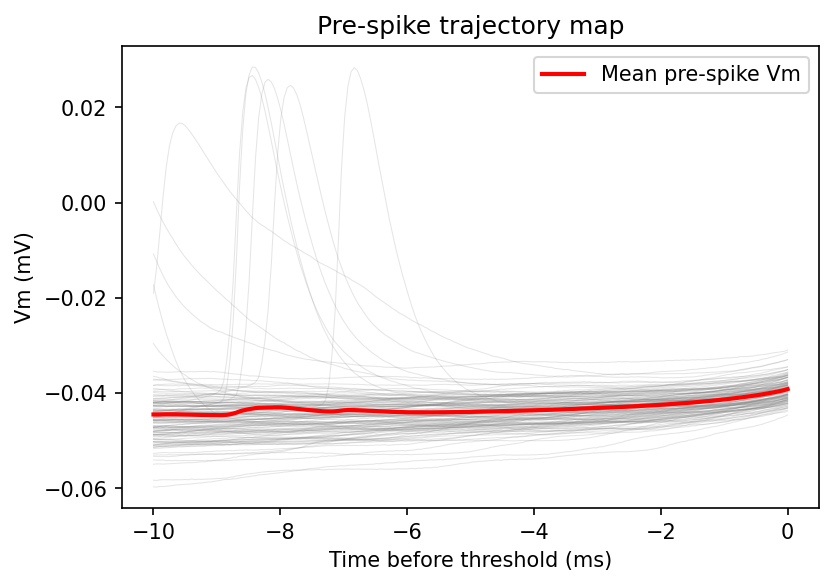

In [186]:
traj_matrix = np.vstack(pre_spike_segments_10ms)
avg_traj = traj_matrix.mean(axis=0)
std_traj = traj_matrix.std(axis=0)
time_axis = np.linspace(-10, 0, traj_matrix.shape[1])  # ms

plt.figure(figsize=(6,4), dpi=150)

# plot all individual trajectories in light gray
for row in traj_matrix:
    plt.plot(time_axis, row, color='gray', alpha=0.2, linewidth=0.5)

# plot mean trajectory in bold
plt.plot(time_axis, avg_traj, color='red', linewidth=2, label='Mean pre-spike Vm')

plt.xlabel("Time before threshold (ms)")
plt.ylabel("Vm (mV)")
plt.title("Pre-spike trajectory map")
plt.legend()
plt.show()

112